<h1>2. Task: Linear CG - Auxiliary Percentage: 100%; Auxiliary Percentage on all problems: 100%</h1>
Program and test the CG method on 2 functions starting from different init. points$\newline$
In section 3 the implemetation on the conjugate gradient and Newtons' Method can be found. Note that the implemented algorithm is programmed accordng to Algorithm 5.2 in the book with the stopping criteria for CG is $||p_k|| \leq 10^{-6}$. Increasing the stopping criteria does not lead to any better solution$\newline$
Section 4 consists of the comparissons of each CG solution to the solution derived by Newtons' Method (as requested in the describtion) using $\textbf{exact derivatives}$.$\newline$
Section 5 consists of the comparissons of each CG solution to the solution derived by Newtons' Method (as requested in the describtion) using $\textbf{approximated derivatives}$. Here we show only the detailed output difference for exact and approximated derivatives and no plots as we solutions are quiete identical if epslion is chosen appropriate enough - see later$\newline$
In section 6 the additional tasks for linear CG are programmed. I.e. 5 additional problems for Hilbert Matrix to compare for each run linear CG with standard SD together with exact line-search.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h2>2. Problems to test linear Conjugate Gradient method</h2>

<h3>Problem 1:</h3>
$$f(x_1, x_2)=100(x_2-x_1^2)^2+(1-x_1)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
-400x_1(x_2-x_1^2)-2(1-x_1)\\ 
200(x_2-x_1^2)\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
1200x_1^2-400x_2+2 & -400x_1\\ 
-400x_1 & 200\\ 
\end{pmatrix}$$
on the starting points $x_0$:
$$(1.2, 1.2), (-1.2, 1), (0.2, 0.8)$$
with the minimum at $x^*=(1,1)$

In [2]:
def fct_1(x: np.array) -> int:
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

def grad_fct_1(x: np.array) -> np.array:
    return np.array([-400*x[0]*(x[1]-x[0]**2)-2*(1-x[0]),
                    200*(x[1]-x[0]**2)], dtype=np.float64)

def hessian_fct_1(x: np.array) -> np.array:
    return np.array([[1200*x[0]**2-400*x[1]+2, -400*x[0]], 
                     [-400*x[0], 200]], dtype=np.float64)

<h3>Problem 2:</h3>
$$f(x_1, x_2)=150(x_1 x_2)^2+(0.5x_1 + 2x_2 - 2)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
300x_2^2 x_1 + 0.5 x_1 + 2x_2 - 2\\ 
300x_1^2 x_2 + 2x_1 + 8x_2 - 8\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
300x_2^2 +0.5 & 600x_1 x_2+2\\ 
600x_1 x_2+2 & 300x_1^2 +8\\ 
\end{pmatrix}$$

on the starting points $x_0$:
$$(-0.2, 1.2), (3.8, 0.1), (1.9, 0.6)$$
with the minimums at $x^*=(0,1)$ and $x^*=(4,0)$ and a saddle point at $(0.43685, 0.10921)$

In [3]:
def fct_2(x: np.array) -> int:
    return 150*(x[0] * x[1])**2 + (0.5 * x[0] + 2*x[1] - 2)**2

def grad_fct_2(x: np.array) -> np.array:
    return np.array([300*x[0]*x[1]**2 + 0.5*x[0]+2*x[1]-2,
                     300*(x[0]**2)*x[1] + 2*x[0]+8*x[1]-8], dtype=np.float64)

def hessian_fct_2(x: np.array) -> np.array:
    return np.array([[300*x[1]**2 + 0.5, 600*x[0]*x[1] + 2], 
                     [600*x[0]*x[1] + 2, 300*x[0]**2 + 8]], dtype=np.float64)

<h2>3. Implementation of linear CG</h2>

In [4]:
max_iterations = 10000
stopping_criteria = 1e-6

exact_dfs = []


def backtracking_line_search(f, grad_f, p_k: np.array, x_k: np.array, rho: float = 0.95,
                             c: float = 0.5) -> float:
    alpha = 1
    # choose alpha
    while f(x_k + alpha * p_k) > f(x_k) + c * alpha * np.dot(grad_f(x_k), p_k):
        alpha = rho * alpha
    if alpha < stopping_criteria: 
        return 1
    return alpha


# Conjugate gradient method that solves the equation Ax=b (A=NxN, x=b=Nx1)
def conjugate_gradient(f, hessian: np.array, x_0: np.array, gradient: np.array, grad_f: np.array, x_star: np.array, approx: bool = False):
    # (NxN * Nx1) - Nx1 = Nx1-Nx1 = Nx1
    r_k = np.dot(hessian, x_0) - gradient
    # Nx1
    p_k = -r_k
    x_k, k = x_0, 0
    x_k_iterations = [x_0]
    df = pd.DataFrame(columns=['Iteration #', 'x_k', 'f(x_k)', 'alpha', 'p_k', '||x_k - x^*||', '||grad_f(x_k)||'])
    
    grad_norm = 0
    if approx:
        grad_norm = np.linalg.norm(grad_approx(f=f, x=x_k))
    else:
        grad_norm = np.linalg.norm(grad_f(x_k))
            
    df.loc[len(df)] = [f'x_{len(df)}', x_k, f(x_k), 1, np.linalg.norm(p_k), np.round(np.linalg.norm(x_k-x_star), 6), grad_norm]
    
    # stopping criterion
    while np.linalg.norm(p_k) > stopping_criteria:
        # 1xN * Nx1 / N * (NxN * NxN) = 1x1 = 1
        alpha_k = np.dot(r_k.T, r_k) / np.dot(p_k.T, np.dot(hessian, p_k))

        # Nx1 + c*Nx1 = Nx1+Nx1 = Nx1
        x_k = x_k + alpha_k * p_k

        # Nx1 + c * (NxN * Nx1) = Nx1
        r_k_plus1 = r_k + alpha_k * np.dot(hessian, p_k)

        # 1xN * Nx1 / 1xN * Nx1  = 1x1 = 1
        beta_k = np.dot(r_k_plus1.T, r_k_plus1) / np.dot(r_k.T, r_k)

        # Nx1 + c*Nx1 = Nx1+Nx1 = Nx1
        p_k_plus1 = -r_k_plus1 + beta_k * p_k
        # print(p_k)

        # set r_k_plus1 and p_k_plus1
        r_k = r_k_plus1
        p_k = p_k_plus1

        # increment number of iterations
        k += 1
        
        # save all x_k's
        x_k_iterations.append(x_k)
        
        grad_norm = 0
        if approx:
            grad_norm = np.linalg.norm(grad_approx(f=f, x=x_k))
        else:
            grad_norm = np.linalg.norm(grad_f(x_k))
        
        df.loc[len(df)] = [f'x_{len(df)}', x_k, f(x_k), alpha_k, np.linalg.norm(p_k), np.round(np.linalg.norm(x_k-x_star), 6), grad_norm]
    x_k_iterations = np.array(x_k_iterations)
    print(k)
    return df, x_k_iterations


def newtons_method(f, grad_f, hessian_f: np.array, x_0: np.array, x_star: np.array):
    x_k_iterations, x_k, alpha = [x_0], x_0, 1
    # define the direction for NM: -hessian_f(x_k)^-1 * grad_f(x_k)
    p_k = -np.linalg.solve(hessian_f(x_k), grad_f(x_k))
    # p_k = -np.dot(np.invert(hessian_f(x_k)), grad_f(x_k))
    converges = False
    
    df = pd.DataFrame(columns=['Iteration', 'x_k', 'f(x_k)', 'alpha', '||p_k||', '||x_k - x^*||', '||grad_f(x_k)||'])
    df.loc[len(df)] = [f'x_{len(df)}', np.round(x_k, 5), np.round(f(x_k), 5), np.round(alpha, 5), np.round(p_k, 5), np.round((x_k + alpha * p_k) - x_k, 5), 
                       np.linalg.norm(x_k)]

    for i in range(max_iterations):
        # define the direction for NM: -hessian_f(x_k)^-1 * grad_f(x_k)
        p_k = -np.linalg.solve(hessian_f(x_k), grad_f(x_k))
        # p_k = -np.dot(np.invert(hessian_f(x_k)), grad_f(x_k))

        # get alpha from backtracking line search method
        alpha = backtracking_line_search(f=f, grad_f=grad_f, p_k=p_k, x_k=x_k, rho=0.5, c=0.05)
        # update next iteration
        x_k_plus1 = x_k + alpha * p_k

        # define difference from current iteration to next iteration
        diff = x_k_plus1 - x_k

        # define stopping criteria
        if np.linalg.norm(grad_f(x_k)) < stopping_criteria:
            print(f'Successful convergence after {i} iterations')
            converges = True
            break

        # update x_k for the next iteration
        x_k = x_k_plus1

        # save all x_k's
        x_k_iterations.append(x_k)

        df.loc[len(df)] = [f'x_{len(df)}', np.round(x_k, 3), np.round(f(x_k), 3), np.round(alpha, 5), np.round(np.linalg.norm(p_k), 6), 
                           np.round(np.linalg.norm(x_k-x_star), 6), 
                           np.linalg.norm(grad_f(x_k))]
    if not converges: print(f'Unsuccessful convergence after {max_iterations} total iterations')
    x_k_iterations = np.array(x_k_iterations)
    return df, x_k_iterations


def _plot_contour_map(f, x_min: float, x_max: float, y_min: float, y_max: float, fct_name: str, x_iter_cg: np.array, x_iter_nm: np.array, x_star: np.array, 
                      x_saddle_point:np.array = []):
    fig, ax = plt.subplots(figsize=(15, 15))

    X1, X2 = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
    Z = f([X1, X2])
    
    CS = ax.contourf(X1, X2, Z, 75)
    fig.colorbar(CS)
    #ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title(f'Contour Lines of f(x1,x2)={fct_name}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    # annotate first and last x_k for cg
    ax.annotate('x0', (x_iter_cg[0, 0], x_iter_cg[0, 1]), size=16)
    ax.annotate(f'x{len(x_iter_cg)-1}', (x_iter_cg[-1, 0], x_iter_cg[-1, 1]), size=16)
    
    # annotate first and last x_k for nm
    ax.annotate('x0', (x_iter_nm[0, 0], x_iter_nm[0, 1]), size=16)
    ax.annotate('x1', (x_iter_nm[1, 0], x_iter_nm[1, 1]), size=16)
    #ax.annotate(f'x{len(x_iter_nm)}', (x_iter_nm[-1, 0], x_iter_nm[-1, 1]), size=16)
    
    ax.annotate('x*', x_star, size=16)
    
    # plot gradient lines for cg
    ax.plot(x_iter_cg[:, 0], x_iter_cg[:, 1], marker='o', color='red', linestyle='solid', label='CG')
    ax.plot(x_iter_nm[:, 0], x_iter_nm[:, 1], marker='o', color='yellow', linestyle='solid', label='NM')
    
    # polt saddle_point
    if x_saddle_point != []:
        ax.plot(x_saddle_point[0], x_saddle_point[1], marker='o', color='green')
        ax.annotate('x_s', x_saddle_point, size=16)
    
    plt.legend()
    plt.show()

<h2>4. Problems to test SD and NM using exact derivatives</h2>

<h3>Problem 1.1:</h3>
$$f(x_1, x_2)=100(x_2-x_1^2)^2+(1-x_1)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
-400x_1(x_2-x_1^2)-2(1-x_1)\\ 
200(x_2-x_1^2)\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
1200x_1^2-400x_2+2 & -400x_1\\ 
-400x_1 & 200\\ 
\end{pmatrix}$$
on the starting points $x_0$:
$$(1.2, 1.2)$$

In [5]:
x_0, x_star = np.array([1.2, 1.2]), np.array([1, 1])

hessian, gradient = hessian_fct_1(x=x_0), grad_fct_1(x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star)
exact_dfs.append(df)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2')
df

2
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.2, 1.2]",5.800000,1.000000,8.581693e+02,0.282843,125.169325
1,x_1,"[0.636746264624515, 1.4006643688621223]",99.177952,0.000697,2.388880e+01,0.540819,322.861726
2,x_2,"[0.004081632653055611, -0.23020408163265405]",6.292012,0.073226,6.916250e-12,1.582800,46.072497


As we can see in our detailed enumeration and later in the plot, linear CG performs quiete poorly for the Rosenbrock function. Reason behind this is, that CG is desinged to solve linear systems of equations of the form $Ax=b$ especially for positive defininte matrices\\
However, the Rosenbrock function is (1.) a non-linear function and (2.) a very narrow valley looking function and ill-conditioned around the solution $x^*=[1.2, 1.2]$ $\to$ CG has problems finding the solution i.e. to converge. We even see a increase of the error between our current iteration and the solution.

In [6]:
eigenvals = np.linalg.eig(hessian_fct_1(x=[1, 1]))[0]
eigenvals.sort()    
print(f'Condition number at solution x*: {np.max(eigenvals)/eigenvals[0]}')

x_0 = np.array([1.2, 1.2])
print(f'Positive definite at x_0={x_0}: {np.all(np.linalg.eigvals(hessian_fct_1(x=[1.2, 1.2])) > 0)}')

eigenvals = np.linalg.eig(hessian_fct_1(x=[1.2, 1.2]))[0]
eigenvals.sort()    
print(f'Condition number at x_0={x_0}: {np.max(eigenvals)/eigenvals[0]}')

Condition number at solution x*: 2508.009601277337
Positive definite at x_0=[1.2 1.2]: True
Condition number at x_0=[1.2 1.2]: 105.26090796020434


As we can see, the Condition Number at our solution is very very large $\to$ small adjustment in our input implies a very large error in the output

<h5>Compare to Newtons' Method<h5>

In [7]:
x_0, x_star = np.array([1.2, 1.2]), np.array([1, 1])

df, x_iter_nm = newtons_method(f=fct_1, grad_f=grad_fct_1, hessian_f=hessian_fct_1, x_0=x_0, x_star=x_star)
print(f'Detailed Newton\'s Method output of f(x1,x2)=100*(x1-x2**2)^2 + (1-x1)^2')
df

Successful convergence after 8 iterations
Detailed Newton's Method output of f(x1,x2)=100*(x1-x2**2)^2 + (1-x1)^2


,Iteration,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.2, 1.2]",5.800,1.0,"[-0.00408, 0.2302]","[-0.00408, 0.2302]",1.697056e+00
1,x_1,"[1.196, 1.43]",0.038,1.0,0.23024,0.472715,3.998201e-01
2,x_2,"[1.098, 1.197]",0.019,0.5,0.50621,0.219877,4.784866e+00
3,x_3,"[1.064, 1.132]",0.004,1.0,0.072991,0.146904,6.563523e-01
4,x_4,"[1.012, 1.021]",0.001,1.0,0.122445,0.024507,1.265832e+00
5,x_5,"[1.004, 1.008]",0.000,1.0,0.015032,0.009491,3.465826e-02
6,x_6,"[1.0, 1.0]",0.000,1.0,0.009394,0.000097,8.019780e-03
7,x_7,"[1.0, 1.0]",0.000,1.0,0.000097,0.0,1.451948e-06
8,x_8,"[1.0, 1.0]",0.000,1.0,0.0,0.0,1.436039e-11


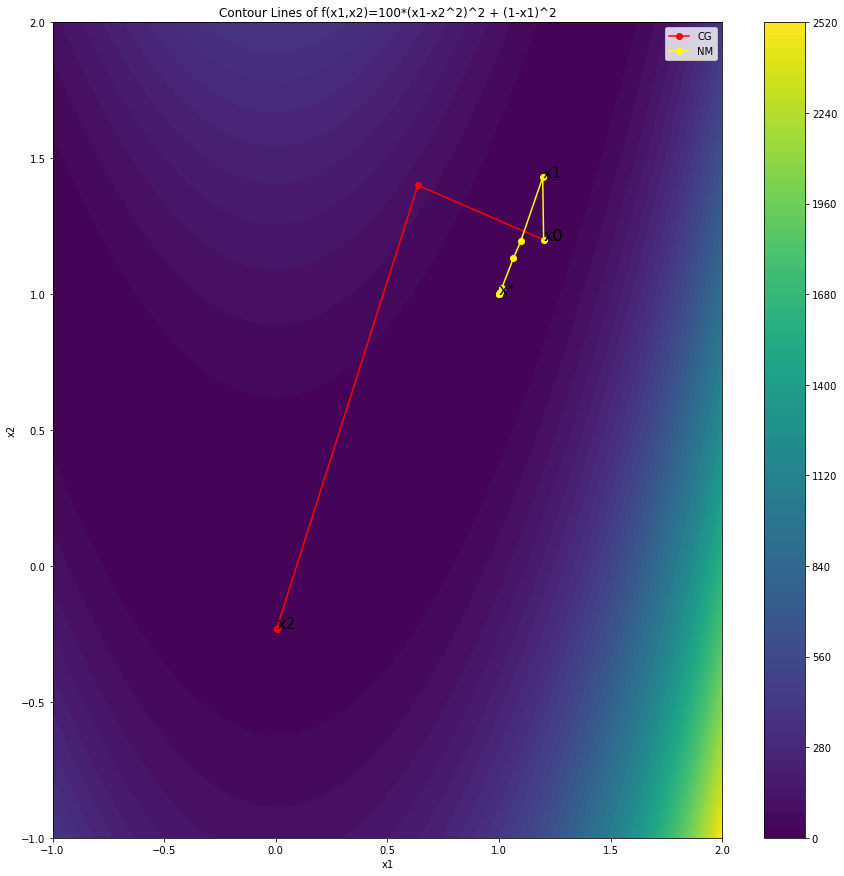

In [8]:
_plot_contour_map(f=fct_1, x_min=-1, x_max=2, y_min=-1, y_max=2, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=x_iter_cg, x_iter_nm=x_iter_nm, x_star=x_star)

As we can see Newtons' Method performs way better compared to the solution of conjugate gradient as NM guarantees to converge to a local minimum while CG struggles to converge to solution as the function is non-linear

<h3>Problem 1.2:</h3>
$$f(x_1, x_2)=100(x_2-x_1^2)^2+(1-x_1)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
-400x_1(x_2-x_1^2)-2(1-x_1)\\ 
200(x_2-x_1^2)\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
1200x_1^2-400x_2+2 & -400x_1\\ 
-400x_1 & 200\\ 
\end{pmatrix}$$
on the starting points $x_0$:
$$(-1.2, 1)$$

In [9]:
x_0, x_star = np.array([-1.2, 1]), np.array([1, 1])

hessian, gradient = hessian_fct_1(x=x_0), grad_fct_1(x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star)
exact_dfs.append(df)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2')
df

2
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-1.2, 1.0]",24.200000,1.000000,9.453381e+02,2.200000,232.867688
1,x_1,"[-0.6012042909782422, 1.1915295026635564]",71.467618,0.000665,3.964556e+01,1.612619,257.179473
2,x_2,"[-0.024719101123596765, -0.3806741573033696]",15.587889,0.042238,1.176785e-12,1.719392,76.478767


In [10]:
x_0 = np.array([-1.2, 1])
print(f'Positive definite at x_0={x_0}: {np.all(np.linalg.eigvals(hessian_fct_1(x=[-1.2, 1])) > 0)}')

eigenvals = np.linalg.eig(hessian_fct_1(x=[-1.2, 1]))[0]
eigenvals.sort()    
print(f'Condition number at x_0={x_0}: {np.max(eigenvals)/eigenvals[0]}')

Positive definite at x_0=[-1.2  1. ]: True
Condition number at x_0=[-1.2  1. ]: 63.739929224619736


Here we have the same problem as mentioned in Problem 1.1 $\to$ CG is not optimal for function of this type!<h5>Compare to Newtons' Method<h5>

In [11]:
x_0, x_star = np.array([-1.2, 1]), np.array([1, 1])

df, x_iter_nm = newtons_method(f=fct_1, grad_f=grad_fct_1, hessian_f=hessian_fct_1, x_0=x_0, x_star=x_star)
print(f'Detailed Newton\'s Method output of f(x1,x2)=100*(x1-x2**2)^2 + (1-x1)^2')
df

Successful convergence after 21 iterations
Detailed Newton's Method output of f(x1,x2)=100*(x1-x2**2)^2 + (1-x1)^2


,Iteration,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-1.2, 1.0]",24.200,1.000,"[0.02472, 0.38067]","[0.02472, 0.38067]",1.562050e+00
1,x_1,"[-1.175, 1.381]",4.732,1.000,0.381476,2.208339,4.639426e+00
2,x_2,"[-0.933, 0.811]",4.087,0.125,4.950945,1.942179,2.855008e+01
3,x_3,"[-0.783, 0.59]",3.229,1.000,0.267738,1.829143,1.157152e+01
4,x_4,"[-0.621, 0.349]",2.768,0.500,0.580108,1.747217,1.457486e+01
5,x_5,"[-0.43, 0.148]",2.179,1.000,0.277389,1.664354,1.173983e+01
6,x_6,"[-0.258, 0.037]",1.670,1.000,0.204139,1.5843,8.090800e+00
7,x_7,"[-0.075, -0.028]",1.268,1.000,0.194026,1.487539,7.393039e+00
8,x_8,"[0.065, -0.015]",0.913,1.000,0.140495,1.380648,4.148611e+00
9,x_9,"[0.255, 0.029]",0.686,1.000,0.195287,1.224244,7.563922e+00


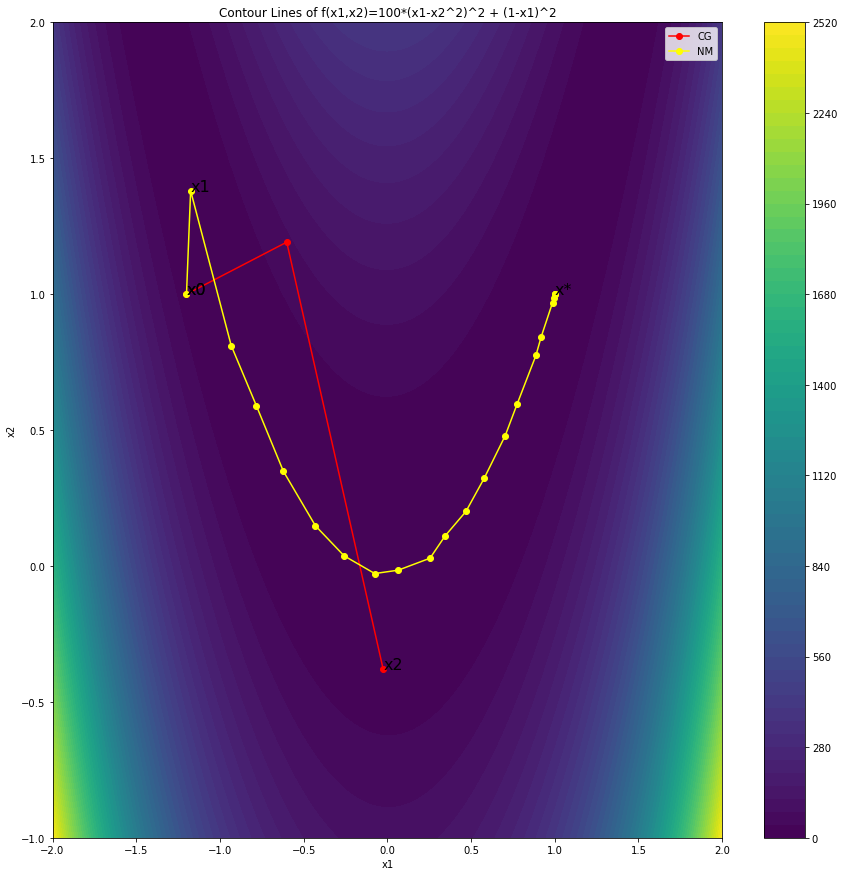

In [12]:
_plot_contour_map(f=fct_1, x_min=-2, x_max=2, y_min=-1, y_max=2, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=x_iter_cg, x_iter_nm=x_iter_nm, x_star=x_star)

And again as expected, NM will converge to our solution and therefore yield a better solution due to the non-linearity of our objective function.

<h3>Problem 1.3:</h3>
$$f(x_1, x_2)=100(x_2-x_1^2)^2+(1-x_1)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
-400x_1(x_2-x_1^2)-2(1-x_1)\\ 
200(x_2-x_1^2)\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
1200x_1^2-400x_2+2 & -400x_1\\ 
-400x_1 & 200\\ 
\end{pmatrix}$$
on the starting points $x_0$:
$$(0.2, 0.8)$$

In [13]:
x_0, x_star = np.array([0.2, 0.8]), np.array([1, 1])

hessian, gradient = hessian_fct_1(x=x_0), grad_fct_1(x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star)
exact_dfs.append(df)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2')
df

2
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[0.2, 0.8]",58.400000,1.000000,5.617259e+01,0.824621,164.309951
1,x_1,"[0.0035485992041523196, 0.7717336113962809]",60.548248,-0.003533,2.085512e+00,1.022263,154.375098
2,x_2,"[0.005298013245033131, 0.7621192052980132]",59.067722,0.004686,4.297366e-15,1.022751,152.460841


In [14]:
x_0 = np.array([0.2, 0.8])
print(f'Positive definite at x_0={x_0}: {np.all(np.linalg.eigvals(hessian_fct_1(x=[0.2, 0.8])) > 0)}')

eigenvals = np.linalg.eig(hessian_fct_1(x=[0.2, 0.8]))[0]
eigenvals.sort()    
print(f'Condition number at x_0={x_0}: {np.max(eigenvals)/eigenvals[0]}')

Positive definite at x_0=[0.2 0.8]: False
Condition number at x_0=[0.2 0.8]: -0.7528631089034938


In this case we even have a negative definite matrix at $x_0$ together with the same problems as mentioned in 1.1

<h5>Compare to Newtons' Method<h5>

In [15]:
x_0, x_star = np.array([0.2, 0.8]), np.array([1, 1])

df, x_iter_nm = newtons_method(f=fct_1, grad_f=grad_fct_1, hessian_f=hessian_fct_1, x_0=x_0, x_star=x_star)
print(f'Detailed Newton\'s Method output of f(x1,x2)=100*(x1-x2**2)^2 + (1-x1)^2')
df

Successful convergence after 13 iterations
Detailed Newton's Method output of f(x1,x2)=100*(x1-x2**2)^2 + (1-x1)^2


,Iteration,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[0.2, 0.8]",58.400,1.00,"[-0.0053, -0.76212]","[-0.0053, -0.76212]",8.246211e-01
1,x_1,"[0.195, 0.038]",0.649,1.00,0.762138,1.254663,1.608420e+00
2,x_2,"[0.395, 0.116]",0.527,0.25,0.859386,1.071387,9.517494e+00
3,x_3,"[0.462, 0.209]",0.291,1.00,0.114736,0.956688,9.326080e-01
4,x_4,"[0.604, 0.342]",0.207,0.50,0.388603,0.768196,6.399346e+00
5,x_5,"[0.676, 0.452]",0.108,1.00,0.131771,0.636562,1.310981e+00
6,x_6,"[0.834, 0.67]",0.089,1.00,0.26933,0.369175,9.375388e+00
7,x_7,"[0.862, 0.742]",0.019,1.00,0.076533,0.293073,1.554433e-01
8,x_8,"[0.922, 0.845]",0.008,0.50,0.239316,0.173522,1.530695e+00
9,x_9,"[0.965, 0.93]",0.002,1.00,0.095187,0.078341,7.700867e-01


<h5>Compare to Newtons' Method<h5>

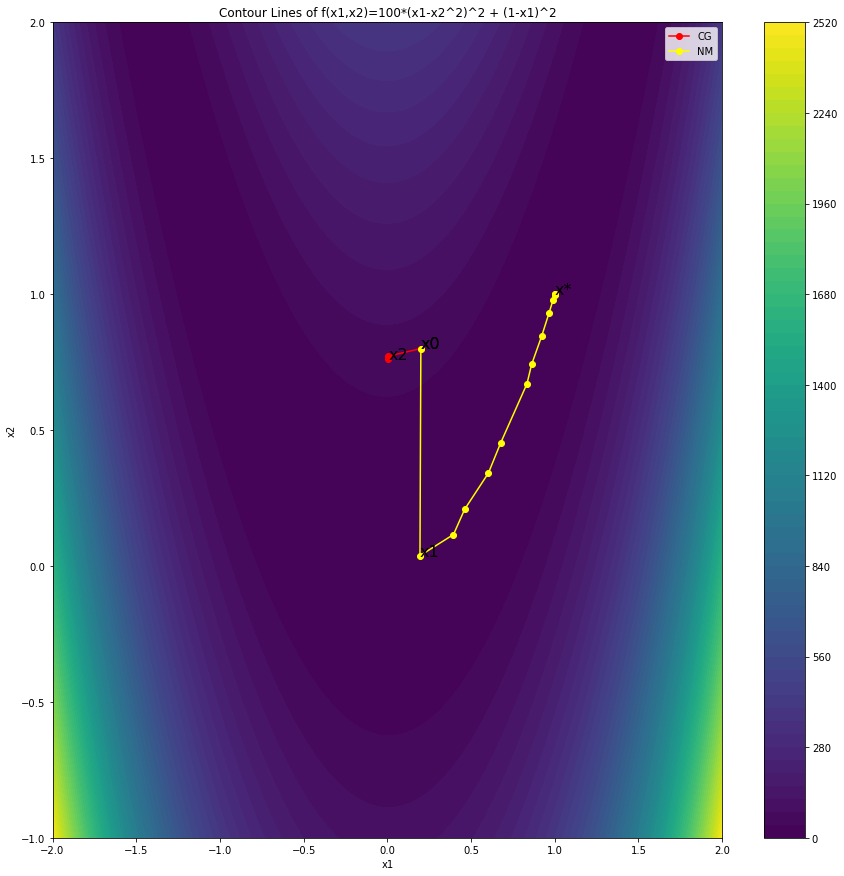

In [16]:
_plot_contour_map(f=fct_1, x_min=-2, x_max=2, y_min=-1, y_max=2, fct_name='100*(x1-x2^2)^2 + (1-x1)^2', x_iter_cg=x_iter_cg, x_iter_nm=x_iter_nm, x_star=x_star)

<h3>Problem 2.1:</h3>
$$f(x_1, x_2)=150(x_1 x_2)^2+(0.5x_1 + 2x_2 - 2)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
300x_2^2 x_1 + 0.5 x_1 + 2x_2 - 2\\ 
300x_1^2 x_2 + 2x_1 + 8x_2 - 8\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
300x_2^2 +0.5 & 600x_1 x_2+2\\ 
600x_1 x_2+2 & 300x_1^2 +8\\ 
\end{pmatrix}$$

on the starting points $x_0$:
$$(-0.2, 1.2)$$
is close to the soltion $x^*=(0,1)$:

In [17]:
x_0, x_star = np.array([-0.2, 1.2]), np.array([0, 1])

hessian, gradient = hessian_fct_2(x=x_0), grad_fct_2(x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_2, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_2, x_star=x_star)
exact_dfs.append(df)
print(f'Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

2
Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-0.2, 1.2]",8.730000,1.000000,1.747194e+02,0.282843,87.501829
1,x_1,"[0.16134705911532105, 1.1221453643123898]",5.022731,0.002116,1.650968e+01,0.202367,62.096828
2,x_2,"[-0.04283480979676754, 0.4758728504429387]",1.206523,-0.041052,7.737825e-13,0.525875,5.654414


In [18]:
eigenvals = np.linalg.eig(hessian_fct_2(x=[0, 1]))[0]
eigenvals.sort()    
print(f'Condition number at solution x_1*={[0, 1]}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[4, 0]))[0]
eigenvals.sort()    
print(f'Condition number at solution x_2*={[4, 0]}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[0.43685072470606, 0.109212681176515]))[0]
eigenvals.sort()    
print(f'Condition number at saddle_points x_s={[0.43685072470606,0.109212681176515]}: {np.max(eigenvals)/eigenvals[0]}')

x_0 = np.array([-0.2, 1.2])
print(f'Positive definite at x_0={x_0}: {np.all(np.linalg.eigvals(hessian_fct_2(x=[-0.2, 1.2])) > 0)}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[-0.2, 1.2]))[0]
eigenvals.sort()    
print(f'Condition number at x_0={x_0}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[-0.04283480979676754, 0.4758728504429387]))[0]
eigenvals.sort()    
print(f'Condition number at x_3={-0.04283480979676754, 0.4758728504429387} on CG: {np.max(eigenvals)/eigenvals[0]}')

x_3 = np.array([-0.04283480979676754, 0.4758728504429387])
print(f'Positive definite at x_3={x_3}: {np.all(np.linalg.eigvals(hessian_fct_2(x=[-0.04283480979676754, 0.4758728504429387])) > 0)}')

Condition number at solution x_1*=[0, 1]: 37.628528585915035
Condition number at solution x_2*=[4, 0]: 9632.030000360592
Condition number at saddle_points x_s=[0.43685072470606, 0.109212681176515]: -9.043966374550177
Positive definite at x_0=[-0.2  1.2]: False
Condition number at x_0=[-0.2  1.2]: -19.73256448984225
Condition number at x_3=(-0.04283480979676754, 0.4758728504429387) on CG: 10.237300093362677
Positive definite at x_3=[-0.04283481  0.47587285]: True


We retrieve the same problem for linear CG as for the Rosenbrock function. Narrow valleys, non-linearity of our objective function, ill-conditioned around our solutions as well as negative definite for our hessian $\to$ CG performs poorly on objective function 2.$\newline$
Also condition number is not very large when going to direction of our saddle_point $\to$ hessian at $x_3$ is not in explicit bad, its even positive definite

<h5>Compare to Newtons' Method<h5>

In [19]:
x_0, x_star = np.array([-0.2, 1.2]), np.array([0, 1])

df, x_iter_nm = newtons_method(f=fct_2, grad_f=grad_fct_2, hessian_f=hessian_fct_2, x_0=x_0, x_star=x_star)
print(f'Detailed Newton\'s Method output of f(x1,x2)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

Successful convergence after 24 iterations
Detailed Newton's Method output of f(x1,x2)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-0.2, 1.2]",8.730,1.00000,"[0.04283, -0.47587]","[0.04283, -0.47587]",1.216553e+00
1,x_1,"[-0.157, 0.724]",2.340,1.00000,0.477797,0.317501,2.551276e+01
2,x_2,"[-0.26, 0.096]",3.848,1.00000,0.636222,0.940411,6.375829e+00
3,x_3,"[-2.22, -0.601]",285.821,1.00000,2.080036,2.737067,9.386470e+02
4,x_4,"[-1.467, -0.398]",63.651,1.00000,0.779516,2.026701,2.809851e+02
5,x_5,"[-0.954, -0.26]",18.219,1.00000,0.531861,1.580316,8.593314e+01
6,x_6,"[-0.585, -0.163]",8.215,1.00000,0.381321,1.301633,2.813786e+01
7,x_7,"[-0.271, -0.085]",5.393,1.00000,0.323093,1.118147,1.146208e+01
8,x_8,"[0.249, 0.011]",3.438,1.00000,0.528988,1.020027,7.446706e+00
9,x_9,"[0.87, -0.065]",3.356,0.03125,20.020689,1.375268,2.158015e+01


C:\Users\Sandro\AppData\Local\Temp\ipykernel_29564\1040895071.py:150: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x_saddle_point != []:


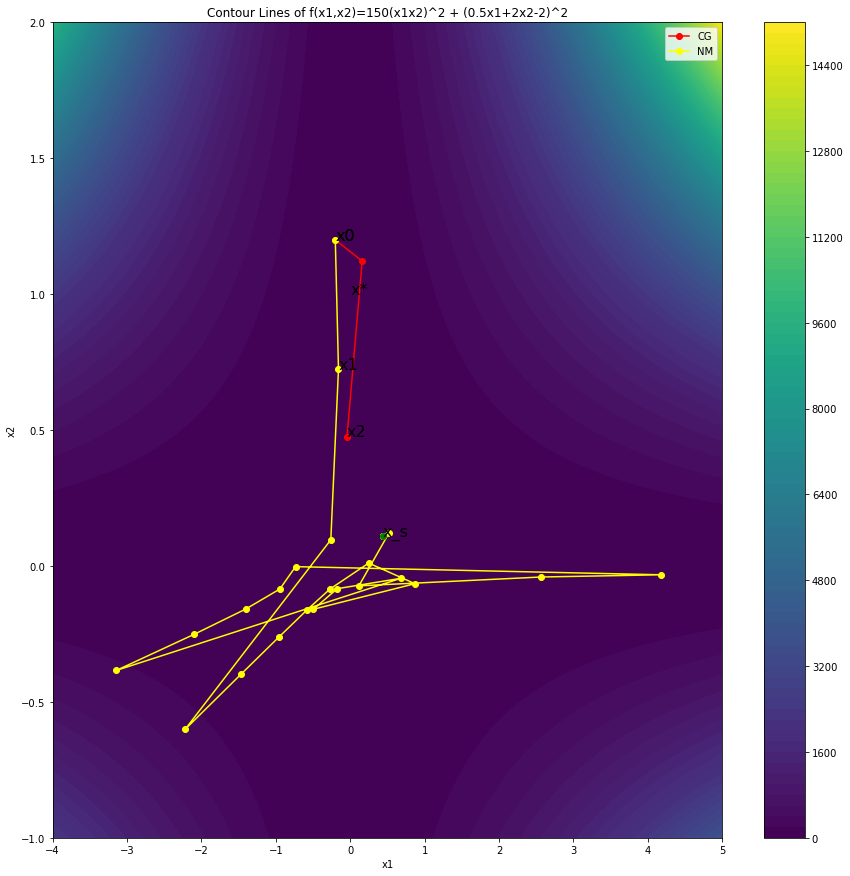

In [20]:
_plot_contour_map(f=fct_2, x_min=-4, x_max=5, y_min=-1, y_max=2, fct_name='150(x1x2)^2 + (0.5x1+2x2-2)^2', x_iter_cg=x_iter_cg, x_iter_nm=x_iter_nm, x_star=x_star, 
                  x_saddle_point=np.array([0.43685072470606, 0.109212681176515]))

Worth mentioning is, that CG tends to go to the direction of our saddle point and not to our soltuion $x^*$.
In addition, we can see that NM converges to the saddle point $x_s$ and not to the closest solution $x^*$ due to the fact that our hessian is strongly ill-conditioned

<h3>Problem 2.2:</h3>
$$f(x_1, x_2)=150(x_1 x_2)^2+(0.5x_1 + 2x_2 - 2)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
300x_2^2 x_1 + 0.5 x_1 + 2x_2 - 2\\ 
300x_1^2 x_2 + 2x_1 + 8x_2 - 8\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
300x_2^2 +0.5 & 600x_1 x_2+2\\ 
600x_1 x_2+2 & 300x_1^2 +8\\ 
\end{pmatrix}$$

on the starting points $x_0$:
$$(3.8, 0.1)$$
is close to the soltion $x^*=(4,0)$:

In [21]:
x_0, x_star = np.array([3.8, 0.1]), np.array([4, 0])

hessian, gradient = hessian_fct_2(x=x_0), grad_fct_2(x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_2, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_2, x_star=x_star)
exact_dfs.append(df)
print(f'Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

2
Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[3.8, 0.1]",21.670000,1.000000,8.747516e+02,0.223607,433.752475
1,x_1,"[3.794298261537804, -0.10103226255419995]",22.136159,0.000230,2.147247e+01,0.229174,437.725240
2,x_2,"[1.3210819411296733, 0.029896579156701797]",1.871533,-0.115342,8.969191e-11,2.679085,10.575075


In [22]:
eigenvals = np.linalg.eig(hessian_fct_2(x=[0, 1]))[0]
eigenvals.sort()    
print(f'Condition number at solution x_1*={[0, 1]}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[4, 0]))[0]
eigenvals.sort()    
print(f'Condition number at solution x_2*={[4, 0]}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[0.43685072470606, 0.109212681176515]))[0]
eigenvals.sort()    
print(f'Condition number at saddle_points x_s={[0.43685072470606,0.109212681176515]}: {np.max(eigenvals)/eigenvals[0]}')

x_0 = np.array([3.8, 0.1])
print(f'Positive definite at x_0={x_0}: {np.all(np.linalg.eigvals(hessian_fct_2(x=[3.8, 0.1])) > 0)}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[3.8, 0.1]))[0]
eigenvals.sort()    
print(f'Condition number at x_0={x_0}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[1.3210819411296733, 0.029896579156701797]))[0]
eigenvals.sort()    
print(f'Condition number at x_3={1.3210819411296733, 0.029896579156701797} on CG: {np.max(eigenvals)/eigenvals[0]}')

x_3 = np.array([1.3210819411296733, 0.029896579156701797])
print(f'Positive definite at x_3={x_3}: {np.all(np.linalg.eigvals(hessian_fct_2(x=[1.3210819411296733, 0.029896579156701797])) > 0)}')

Condition number at solution x_1*=[0, 1]: 37.628528585915035
Condition number at solution x_2*=[4, 0]: 9632.030000360592
Condition number at saddle_points x_s=[0.43685072470606, 0.109212681176515]: -9.043966374550177
Positive definite at x_0=[3.8 0.1]: False
Condition number at x_0=[3.8 0.1]: -502.28950341485006
Condition number at x_3=(1.3210819411296733, 0.029896579156701797) on CG: -1126.413677280862
Positive definite at x_3=[1.32108194 0.02989658]: False


Again as previously mentioned, negative definitness of our hessian paired with ill-condtioned around our solutions. In constrast to 2.1 the condtion number at our soltution is very small and we also have no positive definitness at $x_3$

<h5>Compare to Newtons' Method<h5>

In [23]:
x_0, x_star = np.array([3.8, 0.1]), np.array([4, 0])

df, x_iter_nm = newtons_method(f=fct_2, grad_f=grad_fct_2, hessian_f=hessian_fct_2, x_0=x_0, x_star=x_star)
print(f'Detailed Newton\'s Method output of f(x1,x2)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

Successful convergence after 7 iterations
Detailed Newton's Method output of f(x1,x2)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[3.8, 0.1]",21.670,1,"[-1.32108, -0.0299]","[-1.32108, -0.0299]",3.801316e+00
1,x_1,"[2.479, 0.07]",4.915,1,1.32142,1.522697,1.267914e+02
2,x_2,"[1.451, 0.061]",2.491,1,1.028101,2.549861,3.368963e+01
3,x_3,"[0.662, 0.076]",2.679,1,0.78893,3.338784,3.883931e+00
4,x_4,"[0.415, 0.105]",2.790,1,0.249199,3.58695,9.630819e-01
5,x_5,"[0.438, 0.109]",2.785,1,0.023857,3.563719,4.652990e-02
6,x_6,"[0.437, 0.109]",2.785,1,0.001121,3.56482,9.240548e-05
7,x_7,"[0.437, 0.109]",2.785,1,0.000003,3.564823,3.487235e-10


C:\Users\Sandro\AppData\Local\Temp\ipykernel_29564\1040895071.py:150: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x_saddle_point != []:


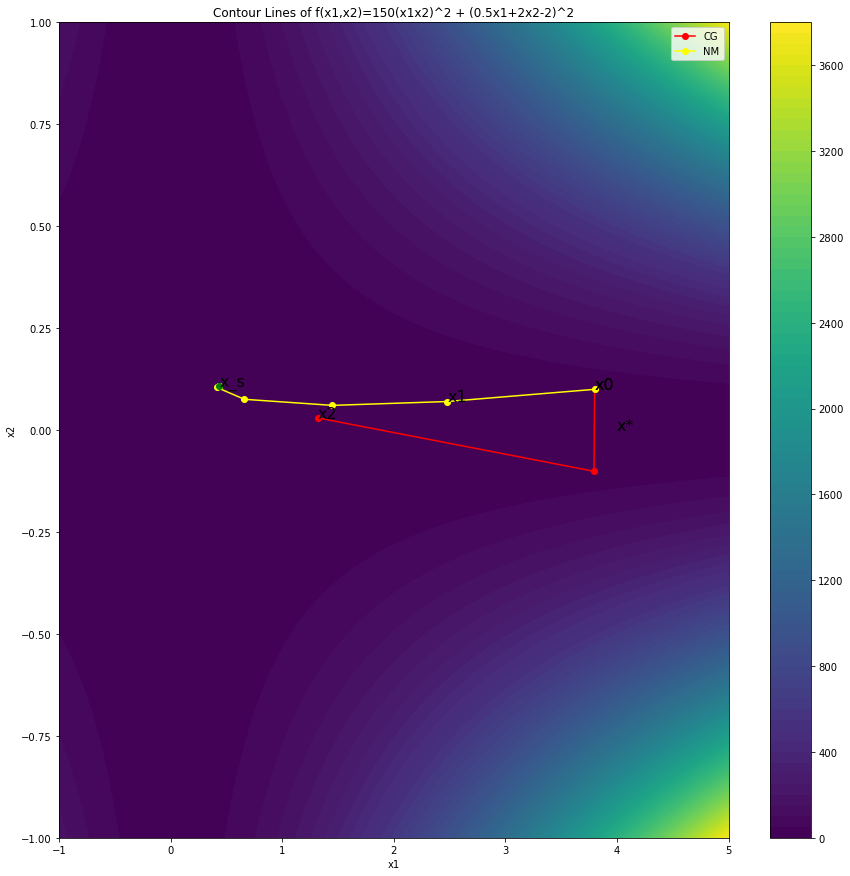

In [24]:
_plot_contour_map(f=fct_2, x_min=-1, x_max=5, y_min=-1, y_max=1, fct_name='150(x1x2)^2 + (0.5x1+2x2-2)^2', x_iter_cg=x_iter_cg, x_iter_nm=x_iter_nm, x_star=x_star, 
                  x_saddle_point=np.array([0.43685072470606, 0.109212681176515]))

NM converges again to our saddle point and CG tends to the direction where the saddle point appears

<h3>Problem 2.3:</h3>
$$f(x_1, x_2)=150(x_1 x_2)^2+(0.5x_1 + 2x_2 - 2)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
300x_2^2 x_1 + 0.5 x_1 + 2x_2 - 2\\ 
300x_1^2 x_2 + 2x_1 + 8x_2 - 8\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
300x_2^2 +0.5 & 600x_1 x_2+2\\ 
600x_1 x_2+2 & 300x_1^2 +8\\ 
\end{pmatrix}$$

on the starting points $x_0$:
$$(1.9, 0.6)$$
close $x^*=(0,1)$

In [25]:
x_0, x_star = np.array([1.9, 0.6]), np.array([0, 1])

hessian, gradient = hessian_fct_2(x=x_0), grad_fct_2(x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_2, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_2, x_star=x_star)
exact_dfs.append(df)
print(f'Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

2
Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.9, 0.6]",194.962500,1.000000,1.371091e+03,1.941649,682.047493
1,x_1,"[1.6045161189350001, -0.3368931204670069]",47.331835,0.000716,2.805914e+02,2.088482,272.832768
2,x_2,"[0.6306739347997352, 0.19959457445222806]",4.029275,-0.003962,6.355287e-13,1.019018,19.693440


In [26]:
eigenvals = np.linalg.eig(hessian_fct_2(x=[0, 1]))[0]
eigenvals.sort()    
print(f'Condition number at solution x_1*={[0, 1]}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[4, 0]))[0]
eigenvals.sort()    
print(f'Condition number at solution x_2*={[4, 0]}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[0.43685072470606, 0.109212681176515]))[0]
eigenvals.sort()    
print(f'Condition number at saddle_points x_s={[0.43685072470606,0.109212681176515]}: {np.max(eigenvals)/eigenvals[0]}')

x_0 = np.array([1.9, 0.6])
print(f'Positive definite at x_0={x_0}: {np.all(np.linalg.eigvals(hessian_fct_2(x=[1.9, 0.6])) > 0)}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[1.9, 0.6]))[0]
eigenvals.sort()    
print(f'Condition number at x_0={x_0}: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[1.6045161189350001, -0.3368931204670069]))[0]
eigenvals.sort()    
print(f'Condition number at x_2={1.6045161189350001, -0.3368931204670069} on CG: {np.max(eigenvals)/eigenvals[0]}')

eigenvals = np.linalg.eig(hessian_fct_2(x=[0.6306739347997352, 0.19959457445222806]))[0]
eigenvals.sort()    
print(f'Condition number at x_3={0.6306739347997352, 0.199594574452228067} on CG: {np.max(eigenvals)/eigenvals[0]}')

x_3 = np.array([0.6306739347997352, 0.19959457445222806])
print(f'Positive definite at x_3={x_3}: {np.all(np.linalg.eigvals(hessian_fct_2(x=[0.6306739347997352, 0.19959457445222806])) > 0)}')

Condition number at solution x_1*=[0, 1]: 37.628528585915035
Condition number at solution x_2*=[4, 0]: 9632.030000360592
Condition number at saddle_points x_s=[0.43685072470606, 0.109212681176515]: -9.043966374550177
Positive definite at x_0=[1.9 0.6]: False
Condition number at x_0=[1.9 0.6]: -5.915882125383506
Condition number at x_2=(1.6045161189350001, -0.3368931204670069) on CG: -10.536168357088313
Condition number at x_3=(0.6306739347997352, 0.19959457445222806) on CG: -6.255234028257053
Positive definite at x_3=[0.63067393 0.19959457]: False


As expected condition number for CG on $x_3$ is rather small and we also see that condition number at $x_2$ is larger as $x_3$ indicating that we're moving into the direction of our saddle point.

<h5>Compare to Newtons' Method<h5>

In [27]:
x_0, x_star = np.array([1.9, 0.6]), np.array([0, 1])

df, x_iter_nm = newtons_method(f=fct_2, grad_f=grad_fct_2, hessian_f=hessian_fct_2, x_0=x_0, x_star=x_star)
print(f'Detailed Newton\'s Method output of f(x1,x2)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

Successful convergence after 11 iterations
Detailed Newton's Method output of f(x1,x2)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.9, 0.6]",194.9625,1.00000,"[-0.63067, -0.19959]","[-0.63067, -0.19959]",1.992486e+00
1,x_1,"[1.269, 0.4]",39.0660,1.00000,0.661504,1.403817,2.006162e+02
2,x_2,"[0.857, 0.269]",9.0210,1.00000,0.432747,1.126775,5.778483e+01
3,x_3,"[0.602, 0.184]",3.6120,1.00000,0.268541,1.014328,1.544436e+01
4,x_4,"[0.472, 0.134]",2.8390,1.00000,0.139049,0.986244,3.189432e+00
5,x_5,"[0.437, 0.113]",2.7850,1.00000,0.041252,0.988804,2.819198e-01
6,x_6,"[0.437, 0.109]",2.7850,1.00000,0.003748,0.991988,1.950876e-03
7,x_7,"[0.437, 0.109]",2.7850,1.00000,0.000189,0.992139,2.834665e-06
8,x_8,"[0.437, 0.109]",2.7850,0.00781,0.0,0.992139,2.812519e-06
9,x_9,"[0.437, 0.109]",2.7850,0.00195,0.0,0.992139,2.807026e-06


C:\Users\Sandro\AppData\Local\Temp\ipykernel_29564\1040895071.py:150: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x_saddle_point != []:


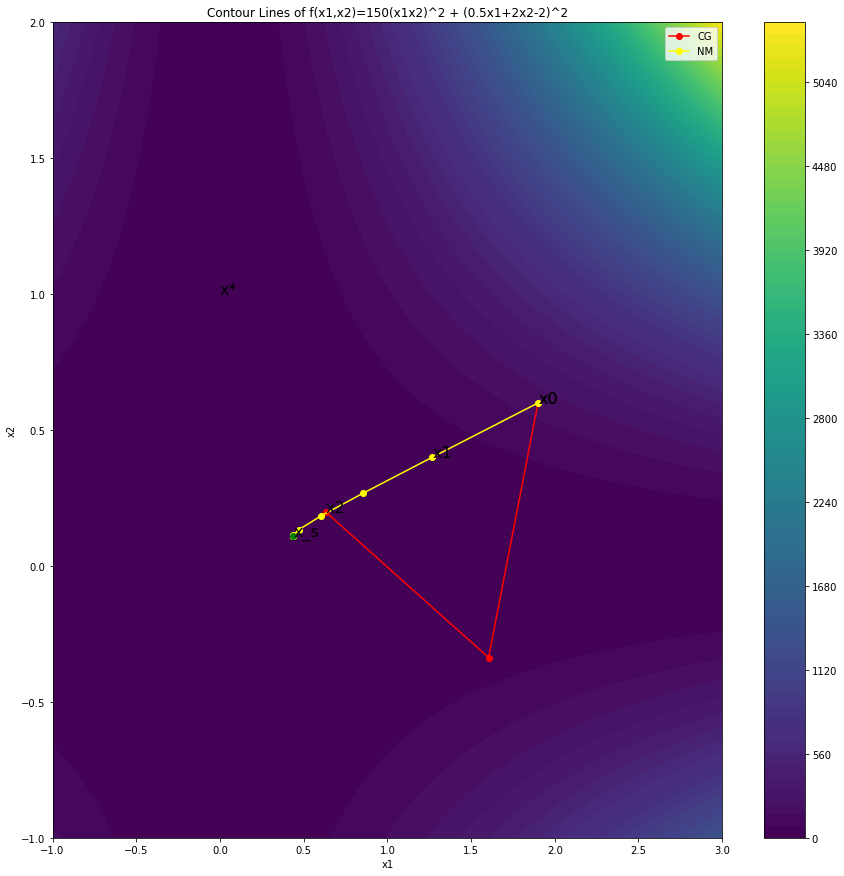

In [28]:
_plot_contour_map(f=fct_2, x_min=-1, x_max=3, y_min=-1, y_max=2, fct_name='150(x1x2)^2 + (0.5x1+2x2-2)^2', x_iter_cg=x_iter_cg, x_iter_nm=x_iter_nm, x_star=x_star, 
                  x_saddle_point=np.array([0.43685072470606, 0.109212681176515]))

And again CG converges into the direction of our saddle point wheres NM converges to saddle point

<h2>4. Problems to test SD and NM using approximated derivatives</h2>
Approximating gradient and hessian are used by the methods of forward-difference and graph coloring techniques mentioned in the book in section 8.1 and plot them again against the output achieved by CG with exact derivatives.

In [29]:
# approximate gradient given a objective function
def grad_approx(f, x: np.array, epsilon: float = 1e-6) -> np.array:
    gradient = np.zeros(len(x))
    for i in range(len(x)):
        unit_vector = np.zeros(len(x))
        unit_vector[i] = 1
        gradient[i] = (f(x + (epsilon * unit_vector)) - f(x)) / epsilon
    return gradient


# approximate hessian given a objective function
def hessian_approx(f, x: np.array, epsilon: float = 1e-6) -> np.array:
    hessian = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        unit_vector = np.zeros(len(x))
        unit_vector[i] = 1
        hessian[:, i] = (grad_approx(f=f, x=(x + (epsilon * unit_vector))) - grad_approx(f=f, x=x)) / epsilon
    return hessian

<h3>Problem 1.1:</h3>
$$f(x_1, x_2)=100(x_2-x_1^2)^2+(1-x_1)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
-400x_1(x_2-x_1^2)-2(1-x_1)\\ 
200(x_2-x_1^2)\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
1200x_1^2-400x_2+2 & -400x_1\\ 
-400x_1 & 200\\ 
\end{pmatrix}$$
on the starting points $x_0$:
$$(1.2, 1.2)$$

In [30]:
x_0, x_star = np.array([1.2, 1.2]), np.array([1, 1])

hessian, gradient = hessian_approx(f=fct_1, x=x_0), grad_approx(f=fct_1, x=x_0)

df, x_iter_approx = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2')
df

2
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.2, 1.2]",5.800000,1.000000,8.581802e+02,0.282843,125.169864
1,x_1,"[0.6367423609091806, 1.4006638172570827]",99.178835,0.000697,2.388994e+01,0.540821,322.862030
2,x_2,"[0.004088016926286575, -0.23018822134503503]",6.291272,0.073222,2.867637e-12,1.582784,46.069215


<h5>Compare to exact derivatives</h5>

In [31]:
exact_dfs[0]

,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.2, 1.2]",5.800000,1.000000,8.581693e+02,0.282843,125.169325
1,x_1,"[0.636746264624515, 1.4006643688621223]",99.177952,0.000697,2.388880e+01,0.540819,322.861726
2,x_2,"[0.004081632653055611, -0.23020408163265405]",6.292012,0.073226,6.916250e-12,1.582800,46.072497


As expected CG using approximation of gradient and hessian yields roughtly the same output as for exact derivatives.

<h3>Problem 1.2:</h3>
$$f(x_1, x_2)=100(x_2-x_1^2)^2+(1-x_1)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
-400x_1(x_2-x_1^2)-2(1-x_1)\\ 
200(x_2-x_1^2)\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
1200x_1^2-400x_2+2 & -400x_1\\ 
-400x_1 & 200\\ 
\end{pmatrix}$$
on the starting points $x_0$:
$$(-1.2, 1)$$

In [32]:
x_0, x_star = np.array([-1.2, 1]), np.array([1, 1])

hessian, gradient = hessian_approx(f=fct_1, x=x_0), grad_approx(f=fct_1, x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2')
df

2
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-1.2, 1.0]",24.200000,1.000000,9.453318e+02,2.200000,232.867034
1,x_1,"[-0.6012066674705722, 1.1915302556343035]",71.467276,0.000665,3.964444e+01,1.612621,257.179463
2,x_2,"[-0.024717574761283778, -0.3806772841309696]",15.588119,0.042240,4.715383e-12,1.719394,76.479255


<h5>Compare to exact derivatives</h5>

In [33]:
exact_dfs[1]

,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-1.2, 1.0]",24.200000,1.000000,9.453381e+02,2.200000,232.867688
1,x_1,"[-0.6012042909782422, 1.1915295026635564]",71.467618,0.000665,3.964556e+01,1.612619,257.179473
2,x_2,"[-0.024719101123596765, -0.3806741573033696]",15.587889,0.042238,1.176785e-12,1.719392,76.478767


And again very similar values

<h3>Problem 1.3:</h3>
$$f(x_1, x_2)=100(x_2-x_1^2)^2+(1-x_1)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
-400x_1(x_2-x_1^2)-2(1-x_1)\\ 
200(x_2-x_1^2)\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
1200x_1^2-400x_2+2 & -400x_1\\ 
-400x_1 & 200\\ 
\end{pmatrix}$$
on the starting points $x_0$:
$$(0.2, 0.8)$$

In [34]:
x_0, x_star = np.array([0.2, 0.8]), np.array([1, 1])

hessian, gradient = hessian_approx(f=fct_1, x=x_0), grad_approx(f=fct_1, x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2')
df

2
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[0.2, 0.8]",58.400000,1.000000,5.617854e+01,0.824621,164.310095
1,x_1,"[0.0035313557653677274, 0.7717184916983738]",60.545968,-0.003533,2.080977e+00,1.022283,154.372096
2,x_2,"[0.005276775760591317, 0.7621248729905232]",59.068662,0.004686,4.440892e-16,1.022770,152.461971


<h5>Compare to exact derivatives</h5>

In [35]:
exact_dfs[2]

,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[0.2, 0.8]",58.400000,1.000000,5.617259e+01,0.824621,164.309951
1,x_1,"[0.0035485992041523196, 0.7717336113962809]",60.548248,-0.003533,2.085512e+00,1.022263,154.375098
2,x_2,"[0.005298013245033131, 0.7621192052980132]",59.067722,0.004686,4.297366e-15,1.022751,152.460841


<h3>Problem 2.1:</h3>
$$f(x_1, x_2)=150(x_1 x_2)^2+(0.5x_1 + 2x_2 - 2)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
300x_2^2 x_1 + 0.5 x_1 + 2x_2 - 2\\ 
300x_1^2 x_2 + 2x_1 + 8x_2 - 8\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
300x_2^2 +0.5 & 600x_1 x_2+2\\ 
600x_1 x_2+2 & 300x_1^2 +8\\ 
\end{pmatrix}$$

on the starting points $x_0$:
$$(-0.2, 1.2)$$
is close to the soltion $x^*=(0,1)$:

In [36]:
x_0, x_star = np.array([-0.2, 1.2]), np.array([0, 1])

hessian, gradient = hessian_approx(f=fct_2, x=x_0), grad_approx(f=fct_2, x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_2, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_2, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

2
Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-0.2, 1.2]",8.730000,1.000000,1.747208e+02,0.282843,87.501618
1,x_1,"[0.1613541372956962, 1.122153079317454]",5.023242,0.002116,1.651494e+01,0.202377,62.100647
2,x_2,"[-0.04285661875397165, 0.4757987740790186]",1.206908,-0.041044,9.979664e-15,0.525950,5.655195


<h5>Compare to exact derivatives</h5>

In [37]:
exact_dfs[3]

,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[-0.2, 1.2]",8.730000,1.000000,1.747194e+02,0.282843,87.501829
1,x_1,"[0.16134705911532105, 1.1221453643123898]",5.022731,0.002116,1.650968e+01,0.202367,62.096828
2,x_2,"[-0.04283480979676754, 0.4758728504429387]",1.206523,-0.041052,7.737825e-13,0.525875,5.654414


<h3>Problem 2.2:</h3>
$$f(x_1, x_2)=150(x_1 x_2)^2+(0.5x_1 + 2x_2 - 2)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
300x_2^2 x_1 + 0.5 x_1 + 2x_2 - 2\\ 
300x_1^2 x_2 + 2x_1 + 8x_2 - 8\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
300x_2^2 +0.5 & 600x_1 x_2+2\\ 
600x_1 x_2+2 & 300x_1^2 +8\\ 
\end{pmatrix}$$

on the starting points $x_0$:
$$(3.8, 0.1)$$
is close to the soltion $x^*=(4,0)$:

In [38]:
x_0, x_star = np.array([3.8, 0.1]), np.array([4, 0])

hessian, gradient = hessian_approx(f=fct_2, x=x_0), grad_approx(f=fct_2, x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_2, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_2, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

2
Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[3.8, 0.1]",21.670000,1.000000,8.747594e+02,0.223607,433.754645
1,x_1,"[3.794301806188297, -0.10103422838914355]",22.137059,0.000230,2.148886e+01,0.229172,437.732400
2,x_2,"[1.320454621208257, 0.029929493014058228]",1.872460,-0.115284,6.369615e-11,2.679713,10.576666


In [39]:
exact_dfs[4]

,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[3.8, 0.1]",21.670000,1.000000,8.747516e+02,0.223607,433.752475
1,x_1,"[3.794298261537804, -0.10103226255419995]",22.136159,0.000230,2.147247e+01,0.229174,437.725240
2,x_2,"[1.3210819411296733, 0.029896579156701797]",1.871533,-0.115342,8.969191e-11,2.679085,10.575075


<h3>Problem 2.3:</h3>
$$f(x_1, x_2)=150(x_1 x_2)^2+(0.5x_1 + 2x_2 - 2)^2$$
$$f'(x_1, x_2)=\begin{pmatrix}
300x_2^2 x_1 + 0.5 x_1 + 2x_2 - 2\\ 
300x_1^2 x_2 + 2x_1 + 8x_2 - 8\\ 
\end{pmatrix}$$
$$f''(x_1, x_2)=\begin{pmatrix}
300x_2^2 +0.5 & 600x_1 x_2+2\\ 
600x_1 x_2+2 & 300x_1^2 +8\\ 
\end{pmatrix}$$

on the starting points $x_0$:
$$(1.9, 0.6)$$
close $x^*=(0,1)$

In [40]:
x_0, x_star = np.array([1.9, 0.6]), np.array([0, 1])

hessian, gradient = hessian_approx(f=fct_2, x=x_0), grad_approx(f=fct_2, x=x_0)

df, x_iter_cg = conjugate_gradient(f=fct_2, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_2, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2')
df

2
Detailed CG output of f(x)=150(x1x2)^2 + (0.5x1+2x2-2)^2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.9, 0.6]",194.962500,1.000000,1.371304e+03,1.941649,682.048029
1,x_1,"[1.6044580205658452, -0.3369282955802072]",47.338185,0.000716,2.805789e+02,2.088459,272.842748
2,x_2,"[0.6306826675164565, 0.19953335298706143]",4.028187,-0.003962,1.741453e-12,1.019072,19.685281


In [41]:
exact_dfs[5]

,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.9, 0.6]",194.962500,1.000000,1.371091e+03,1.941649,682.047493
1,x_1,"[1.6045161189350001, -0.3368931204670069]",47.331835,0.000716,2.805914e+02,2.088482,272.832768
2,x_2,"[0.6306739347997352, 0.19959457445222806]",4.029275,-0.003962,6.355287e-13,1.019018,19.693440


In general, the approximation is very close to the exact derivatives as it heavily depends on the chosen epsilon - should be as close as possible to 0 without exactly being 0. In our case, the epsilon is chosen to be $10^{-6}$ $\newline$
However, choosing a smaller epsilon e.g. $10^{-2}$ would dratmatically change the derivatives of our objective function!

<h4>Try different epsillons on exactly one example</h4>

In [42]:
exact_dfs[0]

,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.2, 1.2]",5.800000,1.000000,8.581693e+02,0.282843,125.169325
1,x_1,"[0.636746264624515, 1.4006643688621223]",99.177952,0.000697,2.388880e+01,0.540819,322.861726
2,x_2,"[0.004081632653055611, -0.23020408163265405]",6.292012,0.073226,6.916250e-12,1.582800,46.072497


In [43]:
x_0, x_star = np.array([1.2, 1.2]), np.array([1, 1])

hessian, gradient = hessian_approx(f=fct_1, x=x_0, epsilon=1e-2), grad_approx(f=fct_1, x=x_0, epsilon=1e-2)

df, x_iter_approx = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2 using approximated derivatives with epsilon=1e-2')
df

9
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2 using approximated derivatives with epsilon=1e-2


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.2, 1.2]",5.800000,1.000000,8.697021e+02,0.282843,125.169864
1,x_1,"[0.6343434562682679, 1.4011545051416765]",99.886435,0.000690,2.280278e+01,0.542798,323.258117
2,x_2,"[0.08252713988058535, -0.030591981386398848]",0.981653,0.067290,3.096199e+00,1.379810,7.504485
3,x_3,"[0.08439967584481554, -0.031619149042416334]",0.988422,0.000690,5.102420e-03,1.379334,7.766038
4,x_4,"[0.08445940801507187, -0.03151068872487178]",0.987551,0.024267,1.153057e-01,1.379213,7.746563
5,x_5,"[0.08452332923524648, -0.03129943779793066]",0.985889,0.001914,4.585431e-04,1.379013,7.706954
6,x_6,"[0.08452303841746144, -0.03129931992906165]",0.985888,0.000684,3.408235e-05,1.379013,7.706921
7,x_7,"[0.08452248190161347, -0.03130044411549828]",0.985897,0.036805,8.577689e-04,1.379014,7.707125
8,x_8,"[0.08452220362888568, -0.03130148367095492]",0.985905,0.001255,4.361843e-06,1.379015,7.707321
9,x_9,"[0.08452220636597328, -0.03130148479921272]",0.985905,0.000679,4.639481e-07,1.379015,7.707321


In [44]:
x_0, x_star = np.array([1.2, 1.2]), np.array([1, 1])

hessian, gradient = hessian_approx(f=fct_1, x=x_0, epsilon=1e-10), grad_approx(f=fct_1, x=x_0, epsilon=1e-10)

df, x_iter_approx = conjugate_gradient(f=fct_1, hessian=hessian, x_0=x_0, gradient=gradient, grad_f=grad_fct_1, x_star=x_star, approx=True)
print(f'Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2 using approximated derivatives with epsilon=1e-10')
df

2
Detailed CG output of f(x)=100(x2-x1^2)^2 + (1-x1)^2 using approximated derivatives with epsilon=1e-10


,Iteration #,x_k,f(x_k),alpha,p_k,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[1.2, 1.2]",5.800000,1.000000,8.629447e+02,0.282843,125.169864
1,x_1,"[0.6351063002297918, 1.4039627307827005]",100.253727,0.000696,1.885045e+01,0.544365,324.091442
2,x_2,"[-0.02953974193546849, -0.31815754838709687]",11.237975,0.097925,2.062868e-11,1.672570,64.071598


<h1>6. Additonal Tasks for linear CG</h1>

In this section the additional tasks for linear CG are programmed. I.e. 5 additional problems for Hilbert Matrix to compare for each run linear CG with standard SD together with exact line-search for comparison.

In [45]:
# generate NxN hilbert matrix N=dim
def generate_hilbert_matrix(dim: int) -> np.array:
    return np.array([np.array([1 / ((i + 1) + j) for j in range(dim)], dtype=np.float64) for i in range(dim)],
                    dtype=np.float64)

def write_details_of_hilbert_matrix(dim: int, _round: bool = False):
    hilbert_matrix = generate_hilbert_matrix(dim=dim)
    # get the eigenvalues of hilbert matrix using SVD
    eigenvals = np.linalg.eig(hilbert_matrix)[0]
    eigenvals.sort()    
    return hilbert_matrix, eigenvals, (eigenvals[-1] - eigenvals[0])/(eigenvals[-1] + eigenvals[0]), np.max(eigenvals)/eigenvals[0]

def solve_equation(Q: np.array, b: np.array) -> np.array:
    return np.linalg.solve(Q, b)

def f_obj(Q: np.array, x: np.array, b: np.array) -> np.array:
    return 1/2 * np.dot(x.T, np.dot(Q, x)) - np.dot(b.T, x)
    
def grad_f_obj(Q: np.array, x: np.array, b: np.array) -> np.array:
    #Q: NxN; x_0: Nx1; b: Nx1
    return b - np.dot(Q, x)


max_iterations = 10000
stopping_criteria = 1e-6
each_nth_iter = 10000


def backtracking_line_search_sd(Q, b, grad, p_k: np.array, x_k: np.array, rho: float = 0.95,
                             c: float = 0.5) -> float:
    alpha = 1
    # choose alpha
    while f_obj(Q=Q, x=(x_k + alpha * grad), b=b) > f_obj(Q=Q, x=x_k, b=b) + c * alpha * np.dot(grad.T, grad):
        alpha = rho * alpha
    if alpha < stopping_criteria: 
        return 1
    return alpha


# Conjugate gradient method that solves the equation Ax=b (A=NxN, x=b=Nx1)
def conjugate_gradient_hilbert(f, hessian: np.array, x_0: np.array, gradient: np.array, grad_f: np.array, x_star: np.array, max_iter=1000000):
    # (NxN * Nx1) - Nx1 = Nx1-Nx1 = Nx1
    r_k = np.dot(hessian, x_0) - gradient
    # Nx1
    p_k = -r_k
    x_k, k = x_0, 0
    df = pd.DataFrame(columns=['Iteration #', 'x_k', 'f(x_k)', 'alpha', '||p_k||', '||x_k - x^*||', '||grad_f(x_k)||'])
    df.loc[len(df)] = [f'x_{len(df)}', x_k, f(Q=hessian, x=x_k, b=gradient), 1, np.linalg.norm(p_k, 2), np.round(np.linalg.norm(x_k-x_star, 2), 6), 
                       np.linalg.norm(grad_f(Q=hessian, x=x_k, b=gradient))]
    iterations = 0
    converges = False
    # stopping criterion
    while np.linalg.norm(p_k) > stopping_criteria and iterations <= max_iter:
        # 1xN * Nx1 / N * (NxN * NxN) = 1x1 = 1
        alpha_k = np.dot(r_k.T, r_k) / np.dot(p_k.T, np.dot(hessian, p_k))

        # Nx1 + c*Nx1 = Nx1+Nx1 = Nx1
        x_k = x_k + alpha_k * p_k

        # Nx1 + c * (NxN * Nx1) = Nx1
        r_k_plus1 = r_k + alpha_k * np.dot(hessian, p_k)

        # 1xN * Nx1 / 1xN * Nx1  = 1x1 = 1
        beta_k = np.dot(r_k_plus1.T, r_k_plus1) / np.dot(r_k.T, r_k)

        # Nx1 + c*Nx1 = Nx1+Nx1 = Nx1
        p_k_plus1 = -r_k_plus1 + beta_k * p_k
        # print(p_k)

        # set r_k_plus1 and p_k_plus1
        r_k = r_k_plus1
        p_k = p_k_plus1

        # increment number of iterations
        k += 1
        # define stopping criteria
        if np.linalg.norm(r_k) < stopping_criteria and iterations <= max_iter:
            print(f'Successful convergence after {iterations} iterations\n')
            converges = True
            break
                
        df.loc[len(df)] = [f'x_{len(df)}', np.round(x_k, 3), f(Q=hessian, x=x_k, b=gradient), alpha_k, np.linalg.norm(p_k, 2), np.round(np.linalg.norm(x_k-x_star, 2), 6), 
                       np.linalg.norm(grad_f(Q=hessian, x=x_k, b=gradient))]
        iterations+=1
    if not converges: print(f'Unsuccessful convergence after {iterations} total iterations!\n')
    return df

def steepest_descent_hilbert(f, Q: np.array, x_0: np.array, b: np.array, x_star: np.array, max_iterations: float=0):
    #Q: NxN; x_0: Nx1; b: Nx1
    x_k, alpha, converges = x_0, 1, False
    df = pd.DataFrame(columns=['Iteration', 'x_k', 'f(x_k)', 'alpha', '||grad_f(x_k)||', '||x_k - x^*||'])
    df.loc[len(df)] = [f'x_{len(df)}', np.round(x_k, 5), np.round(f_obj(Q=Q, x=x_k, b=b), 5), np.round(alpha, 5), np.linalg.norm(grad_f_obj(Q=Q, x=x_k, b=b)), 
                       np.linalg.norm(x_k - x_star)]
    
    if max_iterations != 0: max_iter = max_iterations
    for iterations in range(max_iter):
        # get residual vector: Nx1 - NxN * Nx1 = Nx1 - Nx1 = Nx1
        r_k = grad_f_obj(Q=Q, x=x_k, b=b)

        # get constant alpha: (1xN*Nx1)/(1xN*(NxN*Nx1))=(1x1) /(1xN*Nx1)=(1x1)/(1x1)=1x1
        alpha = backtracking_line_search_sd(Q=Q, b=b, grad=r_k, p_k=r_k, x_k=x_k)

        # Nx1 += 1x1 * Nx1 = Nx1+Nx1=Nx1
        x_k_plus1 = x_k + alpha * r_k
        
        # veryify Therorem 3.3 by calculating x_k_plus1
               
        # save every <each_nth_iter> the current values of SD
        if iterations % each_nth_iter == 0: 
            df.loc[len(df)] = [f'x_{len(df)}', np.round(x_k, 5), np.round(f(Q=Q, x=x_k, b=b), 5), np.round(alpha, 5), np.linalg.norm(grad_f_obj(Q=Q, x=x_k, b=b)), 
                               np.linalg.norm(x_k - x_star)]
        
        # define stopping criteria
        if np.linalg.norm(r_k) < stopping_criteria:
            print(f'Successful convergence after {iterations} iterations\n')
            converges = True
            break
        x_k = x_k_plus1
        
    if not converges: print(f'Unsuccessful convergence after {max_iter} total iterations!\n')
    df.loc[len(df)] = [f'x_{len(df)}', np.round(x_k, 5), np.round(f_obj(Q=Q, x=x_k, b=b), 5), np.round(alpha, 5), np.linalg.norm(grad_f_obj(Q=Q, x=x_k, b=b)), 
                       np.linalg.norm(x_k - x_star)]
    return df

<h3>Problem 1:</h3>
Solve $Q1x=b$ where $Q1$ is the $5x5$ Hilbert Matrix (i.e. $Q1\in\mathbb{R}^{5x5}$) and $b=(1,...,1) \in \mathbb{R}^{5x1}$ for linear CG compared to SD:

In [46]:
Q1, eigenvals, fraction_Q1, condition_nr_Q1 = write_details_of_hilbert_matrix(dim=5, _round = True)
sol_Q1 = solve_equation(Q=Q1, b=np.ones((5, 1)))
print(f'Solution to Q1x=b:\n {sol_Q1}')

Solution to Q1x=b:
 [[    5.]
 [ -120.]
 [  630.]
 [-1120.]
 [  630.]]


In [47]:
df = conjugate_gradient_hilbert(f=f_obj, hessian=generate_hilbert_matrix(dim=5), x_0=np.zeros((5, 1)), gradient=np.ones((5, 1)), grad_f=grad_f_obj, x_star=sol_Q1)
print(f'Detailed CG output of 5x5 Hilbert Matrix')
df

Successful convergence after 5 iterations

Detailed CG output of 5x5 Hilbert Matrix


,Iteration #,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0]]",[[0.0]],1,2.236068,1436.184180,2.236068
1,x_1,"[[0.774], [0.774], [0.774], [0.774], [0.774]]",[[-1.936078672403196]],[[0.7744314689612786]],1.034990,1436.171744,0.952240
2,x_2,"[[-1.733], [1.024], [2.205], [2.895], [3.354]]",[[-3.872635928410932]],[[4.271374558553106]],0.251138,1436.104313,0.242068
3,x_3,"[[2.721], [-12.436], [-2.78], [7.935], [17.219]]",[[-6.3295367034385315]],[[83.85788789537293]],0.043164,1435.173963,0.042466
4,x_4,"[[-3.806], [45.656], [-86.466], [-36.193], [99...",[[-9.21625185895956]],[[3201.429863379758]],0.004705,1413.217986,0.004676
5,x_5,"[[5.0], [-120.0], [630.0], [-1120.0], [630.0]]",[[-12.499999991213485]],[[300339.05540134094]],0.000166,0.000106,0.000166


In [48]:
df = steepest_descent_hilbert(f=f_obj, Q=generate_hilbert_matrix(dim=5), x_0=np.zeros((5, 1)), b=np.ones((5, 1)), x_star=sol_Q1, 
                              max_iterations=1000000)
print(f'Detailed SD output of 5x5 Hilbert Matrix')
df

Unsuccessful convergence after 1000000 total iterations!

Detailed SD output of 5x5 Hilbert Matrix


,Iteration,x_k,f(x_k),alpha,||grad_f(x_k)||,||x_k - x^*||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0]]",[[0.0]],1,2.236068,1436.184180
1,x_1,"[[0.0], [0.0], [0.0], [0.0], [0.0]]",[[0.0]],1,2.236068,1436.184180
2,x_2,"[[-3.22926], [38.54819], [-65.64022], [-57.463...",[[-9.34914]],1,0.004969,1382.994234
3,x_3,"[[-3.24765], [36.03066], [-47.16667], [-93.237...",[[-9.5558]],1,0.004401,1338.246723
4,x_4,"[[-2.99424], [31.10638], [-25.45283], [-126.51...",[[-9.74319]],1,0.004258,1294.961511
...,...,...,...,...,...,...
97,x_97,"[[4.6243], [-112.89892], [599.19854], [-1073.3...",[[-12.49391]],1,0.000200,60.852778
98,x_98,"[[4.63646], [-113.1286], [600.1948], [-1074.82...",[[-12.4943]],1,0.000194,58.884513
99,x_99,"[[4.64821], [-113.35086], [601.15884], [-1076....",[[-12.49466]],1,0.000187,56.979912
100,x_100,"[[4.65959], [-113.56592], [602.0917], [-1077.6...",[[-12.495]],1,0.000181,55.136914


we clearly see the advantage of linear CG over standard SD. CG is optimized for solving linear systems of equations wheres SD is just a simple optimization algorithm that cannot even converge on a $5x5$ hilbert matrix. 

<h3>Problem 2:</h3>
Solve $Q2x=b$ where $Q2$ is the $8x8$ Hilbert Matrix (i.e. $Q2\in\mathbb{R}^{8x8}$) and $b=(1,...,1) \in \mathbb{R}^{8x1}$

In [61]:
Q2, eigenvals, fraction_Q2, condition_nr_Q2 = write_details_of_hilbert_matrix(dim=8, _round = True)
sol_Q2 = solve_equation(Q=Q2, b=np.ones((8, 1)))
print(f'Solution to Q2x=b:\n {sol_Q2}')

Solution to Q2x=b:
 [[-7.99999986e+00]
 [ 5.03999990e+02]
 [-7.55999985e+03]
 [ 4.61999991e+04]
 [-1.38599997e+05]
 [ 2.16215996e+05]
 [-1.68167997e+05]
 [ 5.14799991e+04]]


In [62]:
df = conjugate_gradient_hilbert(f=f_obj, hessian=generate_hilbert_matrix(dim=8), x_0=np.zeros((8, 1)), gradient=np.ones((8, 1)), grad_f=grad_f_obj, x_star=sol_Q2)
print(f'Detailed CG output of 8x8 Hilbert Matrix')
df

Successful convergence after 18 iterations

Detailed CG output of 8x8 Hilbert Matrix


,Iteration #,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,2.828427,314772.662841,2.828427
1,x_1,"[[0.754], [0.754], [0.754], [0.754], [0.754], ...",[[-3.017174434060011]],[[0.7542936085150029]],1.476672,314772.662695,1.335335
2,x_2,"[[-1.713], [0.287], [1.187], [1.733], [2.108],...",[[-5.677044432797896]],[[2.983388224939899]],0.452776,314772.662054,0.426886
3,x_3,"[[2.62], [-7.738], [-5.184], [-1.184], [2.661]...",[[-8.960166114014555]],[[36.03246830687422]],0.110441,314772.655697,0.106750
4,x_4,"[[-3.569], [28.446], [-20.274], [-33.174], [-2...",[[-12.736935894519869]],[[662.8549434857439]],0.022055,314772.560348,0.021588
5,x_5,"[[4.577], [-72.421], [199.841], [-9.995], [-17...",[[-16.950257111356013]],[[18081.460868429556]],0.003527,314770.503033,0.003480
6,x_6,"[[0.449], [0.827], [-150.965], [442.913], [-8....",[[-18.45986425552465]],[[249261.1191439385]],1004.262807,314747.248180,1.857064
7,x_7,"[[-5.65], [153.388], [-873.601], [1378.11], [3...",[[-21.574145563820935]],[[1.806067076467218]],0.000552,314707.028755,0.000545
8,x_8,"[[-5.649], [153.388], [-873.601], [1378.107], ...",[[-21.57414685158153]],[[8.662220556166684]],0.001111,314707.028167,0.000686
9,x_9,"[[7.013], [-289.093], [2802.603], [-9951.056],...",[[-26.582710347244756]],[[21290677.441091802]],1.667323,311883.689125,0.026574


In [51]:
df = steepest_descent_hilbert(f=f_obj, Q=generate_hilbert_matrix(dim=8), x_0=np.zeros((8, 1)), b=np.ones((8, 1)), x_star=sol_Q2, 
                              max_iterations=1000000)
print(f'Detailed SD output of 8x8 Hilbert Matrix')
df

Unsuccessful convergence after 1000000 total iterations!

Detailed SD output of 8x8 Hilbert Matrix


,Iteration,x_k,f(x_k),alpha,||grad_f(x_k)||,||x_k - x^*||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,2.828427,314772.662841
1,x_1,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,2.828427,314772.662841
2,x_2,"[[-0.30005], [-10.77418], [62.17551], [-19.869...",[[-15.37769]],1,0.013062,314771.518936
3,x_3,"[[1.57793], [-33.76376], [109.1082], [-5.16494...",[[-16.46351]],1,0.008076,314770.502752
4,x_4,"[[2.61613], [-45.94965], [130.80197], [10.5862...",[[-16.90557]],1,0.005431,314769.531486
...,...,...,...,...,...,...
97,x_97,"[[-2.49071], [81.83148], [-520.21122], [872.15...",[[-21.20939]],1,0.001093,314697.833437
98,x_98,"[[-2.5267], [82.61273], [-523.75358], [875.947...",[[-21.22121]],1,0.001081,314697.148037
99,x_99,"[[-2.5622], [83.38293], [-527.24209], [879.662...",[[-21.23278]],1,0.001069,314696.463379
100,x_100,"[[-2.59721], [84.14224], [-530.67747], [883.30...",[[-21.24409]],1,0.001058,314695.779447


here is the same expected outcome as above. Linear CG outperforms after 19 iterations standard SG tremendously after 1.000.000 iterations!

<h3>Problem 3:</h3>
Solve $Q3x=b$ where $Q3$ is the $12x12$ Hilbert Matrix (i.e. $Q3\in\mathbb{R}^{12x12}$) and $b=(1,...,1) \in \mathbb{R}^{12x1}$

In [68]:
Q3, eigenvals, fraction_Q3, condition_nr_Q3 = write_details_of_hilbert_matrix(dim=12, _round = True)
sol_Q3 = solve_equation(Q=Q3, b=np.ones((12, 1)))
print(f'Solution to Q3x=b:\n {sol_Q3}')

Solution to Q3x=b:
 [[-1.02203259e+01]
 [ 1.48926122e+03]
 [-5.28997444e+04]
 [ 8.03017450e+05]
 [-6.48770328e+06]
 [ 3.11379829e+07]
 [-9.40750173e+07]
 [ 1.83503668e+08]
 [-2.30600081e+08]
 [ 1.80195086e+08]
 [-7.96148690e+07]
 [ 1.51894793e+07]]


In [70]:
df = conjugate_gradient_hilbert(f=f_obj, hessian=generate_hilbert_matrix(dim=12), x_0=np.zeros((12, 1)), gradient=np.ones((12, 1)), grad_f=grad_f_obj, x_star=sol_Q3)
print(f'Detailed CG output of 12x12 Hilbert Matrix')
df

Successful convergence after 34 iterations

Detailed CG output of 12x12 Hilbert Matrix


,Iteration #,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,3.464102,3.684453e+08,3.464102
1,x_1,"[[0.743], [0.743], [0.743], [0.743], [0.743], ...",[[-4.459325381422711]],[[0.7432208969037853]],1.948465,3.684453e+08,1.740965
2,x_2,"[[-1.739], [-0.123], [0.627], [1.094], [1.422]...",[[-8.02861411990224]],[[2.3552213708705927]],0.695046,3.684453e+08,0.642418
3,x_3,"[[2.618], [-5.434], [-4.925], [-3.079], [-1.06...",[[-12.338752265760942]],[[20.887449937789434]],0.204047,3.684453e+08,0.193961
4,x_4,"[[-3.506], [20.528], [-3.614], [-16.263], [-19...",[[-17.228025158912786]],[[259.9224492526424]],0.052480,3.684453e+08,0.050608
5,x_5,"[[4.422], [-51.514], [85.919], [52.578], [-14....",[[-22.609261859130136]],[[4202.135843113545]],0.011810,3.684453e+08,0.011496
6,x_6,"[[-5.382], [106.643], [-399.672], [216.092], [...",[[-28.44153216587955]],[[88269.24231234285]],0.033017,3.684453e+08,0.017667
7,x_7,"[[-5.375], [106.649], [-399.676], [216.096], [...",[[-28.441620550203822]],[[0.5663745591381946]],0.002359,3.684453e+08,0.002292
8,x_8,"[[6.552], [-195.196], [1275.978], [-2402.359],...",[[-34.67745274124536]],[[2373168.288378983]],8.184056,3.684453e+08,0.135020
9,x_9,"[[6.369], [-196.35], [1282.513], [-2412.374], ...",[[-34.70151558152766]],[[2.639849065284385]],0.000440,3.684453e+08,0.000432


In [54]:
df = steepest_descent_hilbert(f=f_obj, Q=generate_hilbert_matrix(dim=12), x_0=np.zeros((12, 1)), b=np.ones((12, 1)), x_star=sol_Q3, 
                              max_iterations=1000000)
print(f'Detailed SD output of 12x12 Hilbert Matrix')
df

Unsuccessful convergence after 1000000 total iterations!

Detailed SD output of 12x12 Hilbert Matrix


,Iteration,x_k,f(x_k),alpha,||grad_f(x_k)||,||x_k - x^*||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,3.464102,3.684453e+08
1,x_1,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,3.464102,3.684453e+08
2,x_2,"[[2.70476], [-31.46851], [43.36918], [51.97741...",[[-23.16947]],1,0.011671,3.684453e+08
3,x_3,"[[2.52397], [-23.81111], [8.36483], [72.07833]...",[[-24.22859]],1,0.009522,3.684453e+08
4,x_4,"[[1.80105], [-11.55045], [-30.35697], [84.7796...",[[-25.04495]],1,0.008565,3.684453e+08
...,...,...,...,...,...,...
97,x_97,"[[-1.73533], [15.57728], [92.32691], [-524.794...",[[-31.54574]],1,0.001590,3.684453e+08
98,x_98,"[[-1.70427], [14.77119], [96.79004], [-531.603...",[[-31.57091]],1,0.001583,3.684453e+08
99,x_99,"[[-1.67333], [13.96857], [101.23309], [-538.37...",[[-31.59589]],1,0.001577,3.684453e+08
100,x_100,"[[-1.64253], [13.16942], [105.6561], [-545.118...",[[-31.62067]],1,0.001571,3.684453e+08


Here we can see that also linear CG is limited by the 12x12 hilbert matrix. However, CG achieves similar performance of the difference between current iteration and our solution after 35 iterations wheres SD needed 1.000.000 iterations. CG stopped because of our stopping criteria $||p_k||\leq10^{-6}$

<h3>Problem 4:</h3>
Solve $Q4x=b$ where $Q4$ is the $20x20$ Hilbert Matrix (i.e. $Q4\in\mathbb{R}^{20x20}$) and $b=(1,...,1) \in \mathbb{R}^{20x1}$

In [55]:
Q4, eigenvals, fraction_Q4, condition_nr_Q4 = write_details_of_hilbert_matrix(dim=20, _round = True)
sol_Q4 = solve_equation(Q=Q4, b=np.ones((20, 1)))
print(f'Solution to Q4x=b:\n {sol_Q4}')

Solution to Q4x=b:
 [[-7.88099592e+01]
 [ 1.19987266e+04]
 [-4.48010838e+05]
 [ 7.12041109e+06]
 [-5.92207858e+07]
 [ 2.81850133e+08]
 [-7.82124204e+08]
 [ 1.18298972e+09]
 [-7.02994800e+08]
 [-1.06130817e+08]
 [-7.59289383e+08]
 [ 2.59704149e+09]
 [-2.45756969e+09]
 [ 1.96598749e+09]
 [-3.28709889e+09]
 [ 1.46978908e+09]
 [ 4.85531941e+09]
 [-7.63370714e+09]
 [ 4.32398905e+09]
 [-8.95514781e+08]]


In [56]:
df = conjugate_gradient_hilbert(f=f_obj, hessian=generate_hilbert_matrix(dim=20), x_0=np.zeros((20, 1)), gradient=np.ones((20, 1)), grad_f=grad_f_obj, x_star=sol_Q4)
print(f'Detailed CG output of 20x20 Hilbert Matrix')
df

Successful convergence after 70 iterations

Detailed CG output of 20x20 Hilbert Matrix


,Iteration #,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,4.472136,1.158177e+10,4.472136
1,x_1,"[[0.734], [0.734], [0.734], [0.734], [0.734], ...",[[-7.344264340805681]],[[0.7344264340805682]],2.690554,1.158177e+10,2.376025
2,x_2,"[[-1.814], [-0.503], [0.122], [0.521], [0.808]...",[[-12.6327070351301]],[[1.8735082955352962]],1.119527,1.158177e+10,1.008946
3,x_3,"[[2.702], [-3.603], [-4.126], [-3.511], [-2.60...",[[-18.844669549442713]],[[12.204584873330369]],0.387375,1.158177e+10,0.360153
4,x_4,"[[-3.563], [14.662], [3.631], [-4.846], [-9.55...",[[-25.800260319334672]],[[107.24804652426745]],0.122713,1.158177e+10,0.115956
...,...,...,...,...,...,...,...
66,x_66,"[[-10.975], [1050.885], [-23955.505], [220421....",[[-99.63708027056418]],[[0.9473689717200662]],0.000002,1.158176e+10,0.000001
67,x_67,"[[-10.975], [1050.885], [-23955.505], [220421....",[[-99.63711169897579]],[[22.25011380444023]],0.000002,1.158176e+10,0.000001
68,x_68,"[[-10.976], [1050.908], [-23955.59], [220421.1...",[[-99.63714614277706]],[[179807.89401542887]],0.071861,1.158176e+10,0.000244
69,x_69,"[[-10.976], [1050.912], [-23955.603], [220421....",[[-99.63708008406684]],[[0.614253735391369]],0.000774,1.158176e+10,0.000025


In [57]:
df = steepest_descent_hilbert(f=f_obj, Q=generate_hilbert_matrix(dim=20), x_0=np.zeros((20, 1)), b=np.ones((20, 1)), x_star=sol_Q4, 
                              max_iterations=1000000)
print(f'Detailed SD output of 20x20 Hilbert Matrix')
df

Unsuccessful convergence after 1000000 total iterations!

Detailed SD output of 20x20 Hilbert Matrix


,Iteration,x_k,f(x_k),alpha,||grad_f(x_k)||,||x_k - x^*||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,4.472136,1.158177e+10
1,x_1,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,4.472136,1.158177e+10
2,x_2,"[[0.03565], [10.89828], [-49.09271], [2.28088]...",[[-38.88469]],1,0.019189,1.158177e+10
3,x_3,"[[-1.95906], [32.58317], [-80.82101], [-26.074...",[[-41.20621]],1,0.012050,1.158177e+10
4,x_4,"[[-2.72485], [39.18922], [-81.67253], [-48.292...",[[-42.30102]],1,0.009266,1.158177e+10
...,...,...,...,...,...,...
97,x_97,"[[3.15951], [-58.9424], [163.54353], [154.3280...",[[-52.93619]],1,0.001819,1.158177e+10
98,x_98,"[[3.13794], [-58.31107], [159.69057], [160.784...",[[-52.96919]],1,0.001814,1.158177e+10
99,x_99,"[[3.11619], [-57.67717], [155.83283], [167.229...",[[-53.00201]],1,0.001809,1.158177e+10
100,x_100,"[[3.09429], [-57.04094], [151.97114], [173.663...",[[-53.03465]],1,0.001804,1.158177e+10


again same as before 134 to 1.000.000 iterations for CG over standard SD to achieve roughly same difference of current iteraion minus solution

<h3>Problem 5:</h3>
Solve $Q5x=b$ where $Q5$ is the $30x30$ Hilbert Matrix (i.e. $Q5\in\mathbb{R}^{30x30}$) and $b=(1,...,1) \in \mathbb{R}^{30x1}$

In [58]:
Q5, eigenvals, fraction_Q5, condition_nr_Q5 = write_details_of_hilbert_matrix(dim=30)
sol_Q5 = solve_equation(Q=Q5, b=np.ones((30, 1)))
print(f'Solution to Q5x=b:\n {sol_Q5}')

Solution to Q5x=b:
 [[-2.38499425e+01]
 [ 3.80737824e+03]
 [-1.48224869e+05]
 [ 2.43566947e+06]
 [-2.06455532e+07]
 [ 9.72305756e+07]
 [-2.46305974e+08]
 [ 2.26919800e+08]
 [ 4.10214103e+08]
 [-1.35186346e+09]
 [ 1.22587507e+09]
 [ 1.29318576e+07]
 [-2.38287788e+08]
 [-7.87677757e+08]
 [ 4.94157813e+08]
 [ 1.03069980e+09]
 [-3.89546794e+08]
 [-1.84321972e+09]
 [ 9.68064389e+08]
 [ 1.03347837e+09]
 [ 7.76564816e+08]
 [-1.56664353e+09]
 [-7.54286858e+08]
 [-2.57389506e+08]
 [ 2.16715544e+09]
 [-7.51561945e+08]
 [ 2.70164600e+08]
 [-1.20423390e+09]
 [ 8.41966367e+08]
 [-1.46051060e+08]]


In [59]:
df = conjugate_gradient_hilbert(f=f_obj, hessian=generate_hilbert_matrix(dim=30), x_0=np.zeros((30, 1)), gradient=np.ones((30, 1)), grad_f=grad_f_obj, x_star=sol_Q5)
print(f'Detailed CG output of 30x30 Hilbert Matrix')
df

Successful convergence after 166 iterations

Detailed CG output of 30x30 Hilbert Matrix


,Iteration #,x_k,f(x_k),alpha,||p_k||,||x_k - x^*||,||grad_f(x_k)||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,5.477226,4.729314e+09,5.477226
1,x_1,"[[0.73], [0.73], [0.73], [0.73], [0.73], [0.73...",[[-10.950771024451331]],[[0.7300514016300886]],3.423536,4.729314e+09,3.002144
2,x_2,"[[-1.902], [-0.751], [-0.194], [0.166], [0.429...",[[-18.289045260707596]],[[1.6283988389196282]],1.578963,4.729314e+09,1.395158
3,x_3,"[[2.828], [-2.599], [-3.479], [-3.357], [-2.91...",[[-26.709568534534775]],[[8.652115176739812]],0.602891,4.729314e+09,0.550496
4,x_4,"[[-3.696], [11.7], [5.642], [-0.252], [-4.333]...",[[-36.06741869895075]],[[61.758673424511066]],0.215205,4.729314e+09,0.199963
...,...,...,...,...,...,...,...
162,x_162,"[[-12.551], [1386.26], [-36681.364], [396022.9...",[[-161.03215456195176]],[[40.81469957418046]],0.011246,4.729048e+09,0.000124
163,x_163,"[[-12.534], [1385.957], [-36680.173], [396021....",[[-161.03351570200175]],[[2155.9237451407766]],0.011315,4.729048e+09,0.000124
164,x_164,"[[-12.534], [1385.957], [-36680.172], [396021....",[[-161.03319373447448]],[[0.6553307444758941]],0.003180,4.729048e+09,0.000066
165,x_165,"[[-12.534], [1385.957], [-36680.171], [396021....",[[-161.03376347851008]],[[7.390372936146037]],0.000033,4.729048e+09,0.000007


In [60]:
df = steepest_descent_hilbert(f=f_obj, Q=generate_hilbert_matrix(dim=30), x_0=np.zeros((30, 1)), b=np.ones((30, 1)), x_star=sol_Q5, 
                              max_iterations=1000000)
print(f'Detailed SD output of 30x30 Hilbert Matrix')
df

Unsuccessful convergence after 1000000 total iterations!

Detailed SD output of 30x30 Hilbert Matrix


,Iteration,x_k,f(x_k),alpha,||grad_f(x_k)||,||x_k - x^*||
0,x_0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,5.477226,4.729314e+09
1,x_1,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",[[0.0]],1,5.477226,4.729314e+09
2,x_2,"[[-2.32291], [26.04011], [-33.52133], [-40.671...",[[-58.24617]],1,0.020568,4.729314e+09
3,x_3,"[[-1.87665], [14.35595], [8.53746], [-50.07488...",[[-61.38642]],1,0.015819,4.729314e+09
4,x_4,"[[-0.77116], [-2.23901], [51.35783], [-48.9974...",[[-63.5099]],1,0.013401,4.729314e+09
...,...,...,...,...,...,...
97,x_97,"[[-2.90902], [78.22378], [-403.66758], [423.19...",[[-80.29304]],1,0.002082,4.729314e+09
98,x_98,"[[-2.9378], [78.74423], [-405.16023], [422.238...",[[-80.33611]],1,0.002068,4.729314e+09
99,x_99,"[[-2.96584], [79.24846], [-406.57974], [421.21...",[[-80.3786]],1,0.002054,4.729314e+09
100,x_100,"[[-2.99317], [79.73676], [-407.92744], [420.11...",[[-80.42052]],1,0.002041,4.729314e+09


again lastly as before 168 to 1.000.000 iterations for CG over standard SD to achieve roughly same difference of current iteraion minus solution